In [1]:
# Built-in modules
import pickle
import sys
import os
import datetime
import itertools
from enum import Enum

# Machine learning 
import lightgbm as lgb
import joblib

# Basics of Python data handling and visualization
import numpy as np
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Polygon
from tqdm import tqdm_notebook as tqdm

#from sklearn.externals import joblib
# from sklearn import metrics
#from sklearn import preprocessing

# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, \
     LoadFromDisk, SaveToDisk, EOExecutor
from eolearn.io import S2L1CWCSInput, ExportToTiff
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector, AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask
from eolearn.features import LinearInterpolation, SimpleFilterTask, ValueFilloutTask
from sentinelhub import BBoxSplitter, BBox, CRS, CustomUrlParam

C:\Users\bruneautousignantc\AppData\Local\Continuum\anaconda3\envs\arcgispro\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# Set paths
DATA_FOLDER = 'C:\data\predict'

LOGS_FOLDER = os.path.join(DATA_FOLDER, 'logs')
if not os.path.isdir(LOGS_FOLDER):
    os.makedirs(LOGS_FOLDER)
    
path_out = os.path.join(DATA_FOLDER, 'eopatches')
if not os.path.isdir(path_out):
    os.makedirs(path_out)
    
path_out_sampled = os.path.join(DATA_FOLDER, 'eopatches_sampled')
if not os.path.isdir(path_out_sampled):
    os.makedirs(path_out_sampled)
    
tiff_location = os.path.join(DATA_FOLDER, 'predicted_tiff2')
if not os.path.isdir(tiff_location):
    os.makedirs(tiff_location)
    
model_base_name = 'model_200it_7bag_500bin'
model_path = os.path.join(DATA_FOLDER, 'model', '{}.pkl'.format(model_base_name))

In [3]:
class LULC(Enum):
    NO_DATA            = (0,  'No Data',                    'white')
    HAY                = (1,  'Hay',                        '#0cff0c')  # xkcd:neon green
    CORN               = (2,  'Corn',                       '#fe019a')  # xkcd:neon pink
    SOY                = (3,  'Soy',                        '#cfff04')  # xkcd:neon yellow
    VARIOUS_CROPS      = (4,  'Various crops',              '#fa5ff7')  # xkcd:light magenta
    ARTIFICIAL_SURFACE = (5,  'Human-modified environment', 'crimson')
    SHRUBLAND          = (6,  'Old field / Shrubland',      'xkcd:tan')
    FOREST             = (7,  'Forest environment',         'xkcd:darkgreen')
    WETLAND            = (8,  'Wetland',                    'xkcd:lightblue')
    WATER              = (9,  'Open water',                 'xkcd:azure')
    BARELAND           = (10, 'Bare ground',                'xkcd:beige')
    
    def __init__(self, val1, val2, val3):
        self.id = val1
        self.class_name = val2
        self.color = val3
        
# example usecase
# LULC.HAY.id   # return 1
        
# Reference colormap things
nb_class = 11
lulc_cmap = mpl.colors.ListedColormap([entry.color for entry in LULC])
lulc_norm = mpl.colors.BoundaryNorm(np.arange(-0.5, nb_class, 1), lulc_cmap.N)

# Get data

In [22]:
class SentinelHubValidData:
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is assumed to be found in eopatch.mask['CLM']
    """
    def __call__(self, eopatch):        
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool), 
                              np.logical_not(eopatch.mask['CLM'].astype(np.bool)))
    
class CountValid(EOTask):   
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """
    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name
        
    def execute(self, eopatch):
        eopatch.add_feature(FeatureType.MASK_TIMELESS, self.name, np.count_nonzero(eopatch.mask[self.what],axis=0))
        
        return eopatch


class NormalizedDifferenceIndex(EOTask):   
    """
    The tasks calculates user defined Normalised Difference Index (NDI) between two bands A and B as:
    NDI = (A-B)/(A+B).
    """
    def __init__(self, feature_name, band_a, band_b):
        self.feature_name = feature_name
        self.band_a_feature_name = band_a.split('/')[0]
        self.band_b_feature_name = band_b.split('/')[0]
        self.band_a_feature_idx = int(band_a.split('/')[-1])
        self.band_b_feature_idx = int(band_b.split('/')[-1])
        
    def execute(self, eopatch):
        band_a = eopatch.data[self.band_a_feature_name][..., self.band_a_feature_idx]
        band_b = eopatch.data[self.band_b_feature_name][..., self.band_b_feature_idx]
        
        ndi = (band_a - band_b) / (band_a  + band_b)
        
        eopatch.add_feature(FeatureType.DATA, self.feature_name, ndi[..., np.newaxis])
        
        return eopatch

    
class EuclideanNorm(EOTask):   
    """
    The tasks calculates Euclidian Norm of all bands within an array:
    norm = sqrt(sum_i Bi**2),
    where Bi are the individual bands within user-specified feature array.
    """
    def __init__(self, feature_name, in_feature_name):
        self.feature_name = feature_name
        self.in_feature_name = in_feature_name
    
    def execute(self, eopatch):
        arr = eopatch.data[self.in_feature_name]
        norm = np.sqrt(np.sum(arr**2, axis=-1))
        
        eopatch.add_feature(FeatureType.DATA, self.feature_name, norm[..., np.newaxis])
        return eopatch

In [23]:
# TASK FOR BAND DATA
# add a request for B(B02), G(B03), R(B04), NIR (B08), SWIR1(B11), SWIR2(B12) 
# from default layer 'ALL_BANDS' at 10m resolution
# Here we also do a simple filter of cloudy scenes. A detailed cloud cover 
# detection is performed in the next step
custom_script = 'return [B02, B03, B04, B05, B06, B07, B8A, B08, B11, B12];'
add_data = S2L1CWCSInput(
    layer='BANDS-S2-L1C', 
    feature=(FeatureType.DATA, 'BANDS'), # save under name 'BANDS'
    custom_url_params={CustomUrlParam.EVALSCRIPT: custom_script}, # custom url for 10 specific bands
    resx='10m', # resolution x
    resy='10m', # resolution y
    maxcc=0.8, # maximum allowed cloud cover of original ESA tiles
)

# TASK FOR CLOUD INFO
# cloud detection is performed at 80m resolution 
# and the resulting cloud probability map and mask 
# are scaled to EOPatch's resolution
cloud_classifier = get_s2_pixel_cloud_detector(average_over=2, dilation_size=1, all_bands=False)
add_clm = AddCloudMaskTask(cloud_classifier, 'BANDS-S2CLOUDLESS', cm_size_y='80m', cm_size_x='80m', 
                           cmask_feature='CLM', # cloud mask name
                           cprobs_feature='CLP' # cloud prob. map name
                          )

# TASKS FOR CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04)
# NDWI: (B03 - B08)/(B03 + B08)
# NORM: sqrt(B02^2 + B03^2 + B04^2 + B08^2 + B11^2 + B12^2)
ndvi = NormalizedDifferenceIndex('NDVI', 'BANDS/3', 'BANDS/2')
# https://en.wikipedia.org/wiki/Normalized_difference_water_index
ndwi = NormalizedDifferenceIndex('NDWI', 'BANDS/1', 'BANDS/3')  # monitor changes related to water content in water bodies
#ndwi = NormalizedDifferenceIndex('NDWI', 'BANDS/3', 'BANDS/4')  # monitor changes in water content of leaves  
norm = EuclideanNorm('NORM','BANDS')

# TASK FOR VALID MASK
# validate pixels using SentinelHub's cloud detection mask and region of acquisition 
add_sh_valmask = AddValidDataMaskTask(SentinelHubValidData(), 
                                      'IS_VALID' # name of output mask
                                     )

# TASK FOR COUNTING VALID PIXELS
# count number of valid observations per pixel using valid data mask 
count_val_sh = CountValid('IS_VALID', # name of existing mask
                          'VALID_COUNT' # name of output scalar
                         )

# TASK FOR SAVING TO OUTPUT (if needed)
save = SaveToDisk(path_out, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

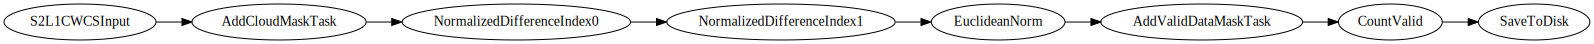

In [24]:
# Define the workflow
workflow = LinearWorkflow(
    add_data,
    add_clm,
    ndvi,
    ndwi,
    norm,
    add_sh_valmask,
    count_val_sh,
    save
)

# Let's visualize it
workflow.dependency_graph()

In [25]:
%%time

# Execute the workflow

time_interval = ['2018-01-01', '2018-12-31']

#bbox = BBox(bbox=[-80.565, 42.576, -80.493, 42.594], crs=CRS.WGS84)
#bbox = BBox(bbox=[583649, 4777412, 593587, 4780648], crs=CRS.UTM_17N)  # zone 1
bbox = BBox(bbox=[568825, 4798822, 579674, 4802434], crs=CRS.UTM_17N)  #zone 2

# define additional parameters of the workflow
execution_args = []

execution_args.append({add_data:{'bbox': bbox, 'time_interval': time_interval}, save: {'eopatch_folder': 'eopatch_1'}})

# execution_args.append({add_data:{'bbox': bbox_list[16], 'time_interval': time_interval}, save: {'eopatch_folder': 'eopatch_{}'.format(0)}})
# for idx, bbox in enumerate(bbox_list[patchIDs[25:26]]):
#     execution_args.append({add_data:{'bbox': bbox, 'time_interval': time_interval},
#                            save: {'eopatch_folder': 'eopatch_{}'.format(idx+25)}})
    
executor = EOExecutor(workflow, execution_args, save_logs=True, logs_folder=LOGS_FOLDER)
executor.run(workers=1, multiprocess=False)  # just 1 worker so we don't exceed per minute limit

executor.make_report()

C:\Users\bruneautousignantc\AppData\Local\Continuum\anaconda3\envs\arcgispro\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide



Wall time: 1min 7s


In [8]:
# # Visualize
# timeframe = 5

# #fig = plt.figure(figsize=(20, 20))
# eopatch = EOPatch.load('{}\eopatch_0'.format(path_out), lazy_loading=True)
# plt.imshow(np.clip(eopatch.data['BANDS'][timeframe][..., [2, 1, 0]] * 3.5, 0, 1))
# plt.xticks([])
# plt.yticks([])
# print(eopatch.timestamp[timeframe])
# del eopatch
# fig.subplots_adjust(wspace=0, hspace=0)

2018-03-13 16:17:02


NameError: name 'fig' is not defined

# Prepare data

In [26]:
class ConcatenateData(EOTask):
    """ Task to concatenate data arrays along the last dimension
    """
    def __init__(self, feature_name, feature_names_to_concatenate):
        self.feature_name = feature_name
        self.feature_names_to_concatenate = feature_names_to_concatenate

    def execute(self, eopatch):
        arrays = [eopatch.data[name] for name in self.feature_names_to_concatenate]

        eopatch.add_feature(FeatureType.DATA, self.feature_name, np.concatenate(arrays, axis=-1))

        return eopatch
    
    
class ValidDataFractionPredicate:
    """ Predicate that defines if a frame from EOPatch's time-series is valid or not. Frame is valid, if the 
    valid data fraction is above the specified threshold.
    """
    def __init__(self, threshold):
        self.threshold = threshold
        
    def __call__(self, array):
        coverage = np.sum(array.astype(np.uint8)) / np.prod(array.shape)
        return coverage > self.threshold

In [27]:
# TASK TO LOAD EXISTING EOPATCHES
load = LoadFromDisk(path_out)

# TASK FOR CONCATENATION
concatenate = ConcatenateData('FEATURES', ['BANDS', 'NDVI', 'NDWI', 'NORM'])

# TASK FOR FILTERING OUT TOO CLOUDY SCENES
# keep frames with > 80 % valid coverage
valid_data_predicate = ValidDataFractionPredicate(0.8)
filter_task = SimpleFilterTask((FeatureType.MASK, 'IS_VALID'), valid_data_predicate)

# TASK FOR LINEAR INTERPOLATION
# linear interpolation of full time-series and date resampling
resampled_range = ('2018-01-01', '2018-12-31', 16)
#resampled_range = ('2017-03-01', '2017-10-31', 16)  # (start_date, end_date, step_days)
linear_interp = LinearInterpolation(
    'FEATURES', # name of field to interpolate
    mask_feature=(FeatureType.MASK, 'IS_VALID'), # mask to be used in interpolation
    #copy_features=[(FeatureType.MASK_TIMELESS, 'LULC')], # features to keep
    resample_range=resampled_range, # set the resampling range
    bounds_error=False # extrapolate with NaN's
)

# TASK FOR EROSION
# erode each class of the reference map
#erosion = ErosionTask(mask_feature=(FeatureType.MASK_TIMELESS,'LULC','LULC_ERODED'), disk_radius=1)

# TASK FOR SPATIAL SAMPLING
# Uniformly sample about pixels from patches
#nb_class = 11
#n_samples = int(4e4) # no. of pixels to sample
# n_samples = int(4e4) # no. of pixels to sample
# ref_labels = list(range(nb_class)) # reference labels to take into account when sampling
# spatial_sampling = PointSamplingTask(
#     n_samples=n_samples, 
#     ref_mask_feature='LULC_ERODED', 
#     ref_labels=ref_labels, 
#     sample_features=[  # tag fields to sample
#         (FeatureType.DATA, 'FEATURES'),
#         (FeatureType.MASK_TIMELESS, 'LULC_ERODED')
#     ])


save = SaveToDisk(path_out_sampled, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

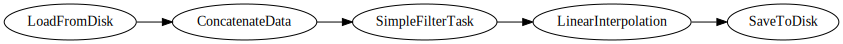

In [28]:
# Define the workflow
workflow = LinearWorkflow(
    load,
    concatenate,
    filter_task,
    linear_interp,
    save
)
# Let's visualize it
workflow.dependency_graph()

In [29]:
%%time
   
execution_args = []
execution_args.append({load: {'eopatch_folder': 'eopatch_1'}, save: {'eopatch_folder': 'eopatch_1'}})

    
executor = EOExecutor(workflow, execution_args, save_logs=True, logs_folder=LOGS_FOLDER)
executor.run(workers=1, multiprocess=False)

executor.make_report()


Wall time: 26.2 s


# Predict

In [4]:
class PredictPatch(EOTask):
    """
    Task to make model predictions on a patch. Provide the model and the feature, 
    and the output names of labels and scores (optional)
    """
    def __init__(self, model, features_feature, predicted_labels_name, predicted_scores_name=None):
        self.model = model
        self.features_feature = features_feature
        self.predicted_labels_name = predicted_labels_name
        self.predicted_scores_name = predicted_scores_name
        
    def execute(self, eopatch):
        ftrs = eopatch[self.features_feature[0]][self.features_feature[1]]
        
        t, w, h, f = ftrs.shape
        ftrs = np.moveaxis(ftrs, 0, 2).reshape(w * h, t * f)
        
        plabels = self.model.predict(ftrs)
        plabels = plabels.reshape(w, h)
        plabels = plabels[..., np.newaxis]
        eopatch.add_feature(FeatureType.MASK_TIMELESS, self.predicted_labels_name, plabels)
        
        if self.predicted_scores_name:
            pscores = self.model.predict_proba(ftrs)
            _, d = pscores.shape
            pscores = pscores.reshape(w, h, d)
            eopatch.add_feature(FeatureType.DATA_TIMELESS, self.predicted_scores_name, pscores)
        
        return eopatch

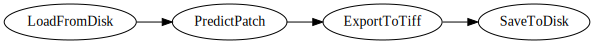

In [5]:
# TASK TO LOAD EXISTING EOPATCHES
load = LoadFromDisk(path_out_sampled)

# TASK FOR PREDICTION
model = joblib.load(model_path)

predict = PredictPatch(model, (FeatureType.DATA, 'FEATURES'), 'LBL_GBM', 'SCR_GBM')

# TASK FOR CLEANING SPECKLES
#clean_speckles = ValueFilloutTask('LBL_GBM') 
#clean_speckles = ValueFilloutTask(feature=(FeatureType.MASK_TIMELESS,'LBL_GBM'), operations='fb')

# TASK TO EXPORT TIFF
export_tiff = ExportToTiff((FeatureType.MASK_TIMELESS, 'LBL_GBM'))
    
# TASK FOR SAVING
save = SaveToDisk(path_out_sampled, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)
#save = SaveToDisk('./eopatches_sampled_small1/', overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

workflow = LinearWorkflow(
    load,
    predict,
    export_tiff,
    save
)
workflow.dependency_graph()

In [6]:
%%time

execution_args = []

execution_args.append({load: {'eopatch_folder': 'eopatch_1'},
                       export_tiff: {'filename': '{}/prediction_eopatch_2.tiff'.format(tiff_location)},
                       save: {'eopatch_folder': 'eopatch_1'}})

executor = EOExecutor(workflow, execution_args, save_logs=True, logs_folder=LOGS_FOLDER)

executor.run(workers=1, multiprocess=False)
executor.make_report()


Wall time: 1min 34s


# Post processing raster

In [18]:
from arcpy.sa import *

strRasterPath = os.path.join(tiff_location, 'prediction_eopatch_100.tiff')

majFilter = MajorityFilter(strRasterPath, number_neighbors='FOUR', majority_definition='MAJORITY')
